In [4]:
import pandas as pd
import plotly.express as px
from time import sleep
import ipywidgets as widgets
from rocket import *
# pri rocket 40 speed 

In [2]:
class Control():
    def __init__(self,env):
        self.env = env
        self.reset()
        
    def reset(self):
        self.errint_alt,self.errint_ang = 0,0
        self.rocket_state = []
        self.pid_state = []
        
    def pid(self,state,params):
        #params
        kp_alt, ki_alt, kd_alt, kp_ang, ki_ang, kd_ang = params
        ki_max = 1.5
        #kp_ang, ki_ang, kd_ang = 39.30850588 ,0, -7.83525488
        #kp_alt,ki_alt,kd_alt = 4.23279606 ,-0.2, -5.1
        #ki_alt=-0.05
        # Calculate setpoints (target values)
        alt_tgt = -1.1 # malku poveke za hover slam 
        ang_tgt = (.02*np.pi)*(state[0]+state[7])

        # Calculate error values
        alt_error = (alt_tgt - state[1])
        ang_error = (ang_tgt - state[2])
        self.errint_alt += ki_alt * alt_error / 60

        # Use PID to get adjustments
        alt_adj = kp_alt*alt_error + kd_alt*state[8] -  np.clip(self.errint_alt, 0,ki_max)
        ang_adj = kp_ang*ang_error + kd_ang*state[9]
       
        if checkbox.value:
            self.pid_state.append([alt_error,kp_alt*alt_error,kd_alt*state[8],np.clip(self.errint_alt, 0,ki_max),alt_adj,
                                   ang_error,ang_adj])

        a = np.array([-0.5*ang_adj,alt_adj,ang_adj])
        a = np.clip(a, -1, +1)

        # If the legs are on the ground we made it, kill engines ne raboti oti ima delay 
        if(state[3] or state[4]):
            a = [0,-1,0]   

        return a

    def run(self,params, verbose=False):
        """ runs an episode given pid parameters """
        done = False
        self.reset()
        state = self.env.reset()
        if verbose:
            self.env.render()
            sleep(.005)
        self.rocket_state.append(state)
        total = 0
        while not done:
            a = self.pid(state,params)
            state,reward,done,_ = self.env.step(a)
            total += reward
            if verbose:
                self.env.render()
                sleep(.005)
            self.rocket_state.append(state)
        return total

    def optimize(self,params, current_score, step):
        """ runs a step of randomized hill climbing """

        # add gaussian noise (less noise as n_steps increases)
        test_params = params + np.random.normal(0,5.0/step,size=params.shape)

        # test params over 5 trial avg
        scores = []
        for trial in range(5):
            score = self.run(test_params)
            scores.append(score)
        avg = np.mean(scores)

        # update params if improved
        if avg > current_score:
            return test_params,avg
        else:
            return params,current_score
        
    def debug(self):
        states = np.array(self.rocket_state).reshape(len(self.rocket_state),-1)
        f = pd.DataFrame({ 'x' : states[:,0],
                           'y' : states[:,1],
                           'theta' : states[:,2],
                           'throtole' : states[:,5],
                           'gimbal' : states[:,6],
                           'vx' : states[:,7],
                           'vy' : states[:,8],
                           'vtheta' : states[:,9]})
                      
        fig = px.line(f)
        fig.show()
        states = np.array(self.pid_state).reshape(len(self.pid_state),-1)
        f = pd.DataFrame({ 'alt_err' : states[:,0],
                           'alt_kp' : states[:,1],
                           'alt_kd' : states[:,2],
                           'alt_ki' : states[:,3],
                           'alt_adj' : states[:,4],
                           'ang_err' : states[:,5],
                           'ang_adj' : states[:,6]
                         })
                      
        fig = px.line(f)
        fig.show()
        return

In [3]:
 # [  4.27211145, -33.78077963,  -4.66952633, -28.28350785] prvo uspesno so -1.7

#params = [-26.88600218 ,  0.52716725  , 6.16273907  ,-6.22482856]
#params =  [  4.27211145, -33.78077963,  -4.66952633, -28.28350785]
#params = [   8.1 , -65.9 , -54.9, -112.5 ]   
#params =  [-29.99108709, -77.15419284, -38.15949774, -28.9345093 ] 
#params =  [ 17.39319427, -39.69714531,  70.42516888, -30.91837916]
#params = [-35.65520591 , 30.40344084,  53.49326454, -25.74506989]
#params = [ 72.37779617 ,-58.05705871  ,39.10013901 , -5.17177033]
#params = [ 2.0,0, -2.15 , 39.30850588 ,0, -7.83525488]
#params = [ 6.17253262 , 4.71326181, -5.24454456,  2.15839052, 10.634164,    3.72327368]
#params = [  7.30007977 , 15.52354282,  -6.18132058 , -7.59530288 , 12.14769334,-24.05550596]
#params = [ 4.23279606 ,-6.77798772, -2.64757269 , 8.98776616, -5.39269594, -4.27016228]
params = [4.23279606 ,-0.2, -5.25 ,  39.30850588 ,0, -7.83525488] # best so far

def simulate(button):
    params = np.array([widget_params[0].value, widget_params[1].value, widget_params[2].value,
                       widget_params[3].value, widget_params[4].value, widget_params[5].value])
    cnt = Control(RocketLander())
    cnt.env.maxstep = 1000
    cnt.env.seed()
    score = cnt.run(params,True)
    cnt.env.close()
    print ("Score:",score)
    if checkbox.value:
        cnt.debug()
        
widget_params = [widgets.FloatSlider(
    value=params[i],
    min=-40,
    max=40,
    step=0.01,
    description=name,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f'
)for i,name in enumerate(['Kp','Ki','Kd','Kp','Ki','Kd'])]
button = widgets.Button(
    description='Start',
    disabled=False,
    button_style='',
    tooltip='Click me',
    icon='check'
)
checkbox = widgets.Checkbox(
    value=False,
    description='Debug',
    disabled=False,
    indent=False
)
button.on_click(simulate)
center_layout = widgets.Layout(display='flex',flex_flow='column',align_items='center')
alt_box = widgets.VBox([widgets.Label("Altitude",layout = center_layout), widget_params[0], widget_params[1], widget_params[2]])
ang_box = widgets.VBox([widgets.Label("Anagle",layout = center_layout), widget_params[3], widget_params[4], widget_params[5]])
cnt_box = widgets.VBox([widgets.Label("Simulation"),button,checkbox])
widgets.HBox([alt_box, ang_box,cnt_box])

Step: 0 Score: 1 Params: [ 4.23279606 -0.2        -5.1        39.30850588  0.         -7.83525488]
Step: 10 Score: 1 Params: [ 4.23279606 -0.2        -5.1        39.30850588  0.         -7.83525488]
Step: 20 Score: 1 Params: [ 4.23279606 -0.2        -5.1        39.30850588  0.         -7.83525488]
Step: 30 Score: 1 Params: [ 4.23279606 -0.2        -5.1        39.30850588  0.         -7.83525488]
Step: 40 Score: 1 Params: [ 4.23279606 -0.2        -5.1        39.30850588  0.         -7.83525488]
Step: 50 Score: 1 Params: [ 4.23279606 -0.2        -5.1        39.30850588  0.         -7.83525488]
Average Score: 1.1184828141948842


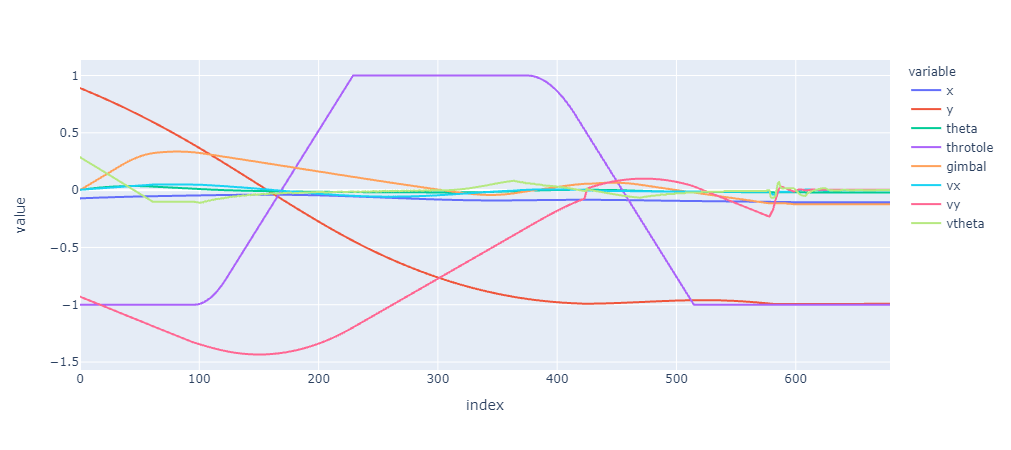

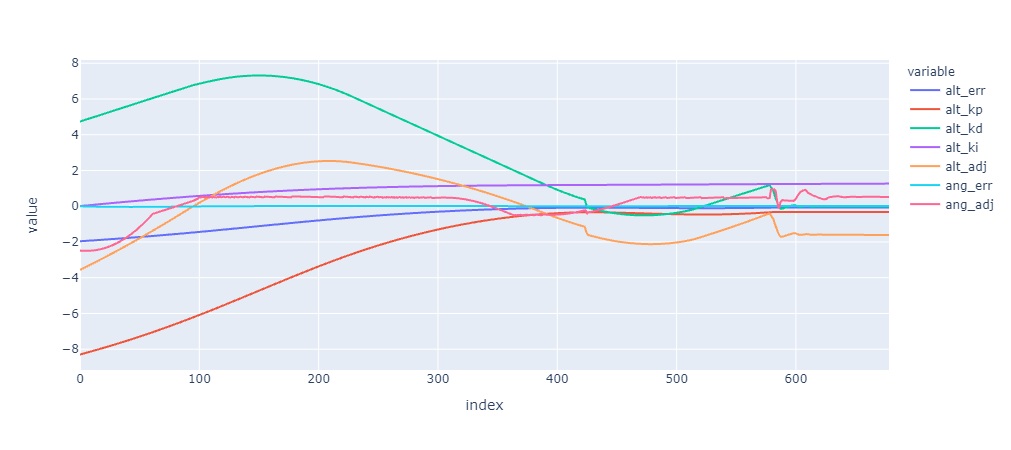

In [12]:
params = np.array([4.23279606 ,-0.2, -5.1 ,  39.30850588 ,0, -7.83525488])
cnt = Control(RocketLander())
cnt.env.maxstep = 900
cnt.env.seed()
score = 1
for steps in range(51):
    params,score = cnt.optimize(params,score,steps+1)
    if steps%10 == 0:
        print( "Step:",steps,"Score:",score,"Params:",params)

# Get data for final run
scores = []
for trial in range(1):
    score = cnt.run(params,True)
    scores.append(score)
cnt.env.close()
print ("Average Score:",np.mean(scores))
cnt.debug()